# **Random Forest Training & Evaluation Pipeline** 

This notebook automates data loading, preprocessing, model training with hyperparameter tuning, evaluation, and basic visualizations for our Heron WellNest project.

---

## **Setup and Imports**

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

---
## **Configurations**


In [2]:
DATA_PATH = '../../data/classification/synthetic_dataset.csv'
# Path where the trained model will be saved
MODEL_PATH = '../../models/classification/random_forest.joblib'
MODEL_LABEL = '../../models/classification/random_forest_label_encoder.joblib'

---
## **Load Data**


In [3]:
df = pd.read_csv(DATA_PATH)

target_col = 'WellbeingClass'

labels = df[target_col].unique()
feature_cols = ["p_anxiety", "p_normal", "p_depression", "p_suicidal", "p_stress", "gratitude_flag",
                "Depressed","Sad","Exhausted","Hopeless","Anxious",
                "Angry","Stressed","Restless","Calm","Relaxed",
                "Peaceful","Content","Happy","Energized","Excited",'Motivated']

print(df[target_col].value_counts())
df.head()

WellbeingClass
Struggling    3771
Thriving      2728
InCrisis      2598
Excelling      903
Name: count, dtype: int64


,p_anxiety,p_normal,p_depression,p_suicidal,p_stress,gratitude_flag,WellbeingClass,Depressed,Sad,Exhausted,...,Peaceful,Content,Happy,Energized,Excited,Motivated,flipfeel_incrisis_pct,flipfeel_struggling_pct,flipfeel_thriving_pct,flipfeel_excelling_pct
0,0.140475,0.181060,0.330063,0.135326,0.213077,0,Struggling,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,1,Excelling,0,0,0,...,0,0,1,0,0,1,0.4,0.0,0.0,0.6
2,0.000000,0.000000,0.000000,0.000000,0.000000,0,Thriving,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0,Struggling,0,0,0,...,0,0,0,0,0,0,0.0,1.0,0.0,0.0
4,0.009923,0.071636,0.357258,0.424961,0.136221,0,InCrisis,0,1,0,...,0,0,0,0,0,0,1.0,0.0,0.0,0.0


----
## **Data visualization**


### **1. Target Distribution**


C:\Users\PC\AppData\Local\Temp\ipykernel_24748\1134603404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette="Set2")


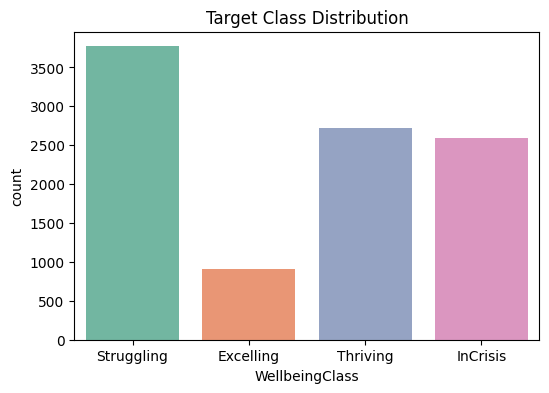

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df, palette="Set2")
plt.title("Target Class Distribution")
plt.show()

### **2. Feature Distributions per Class**


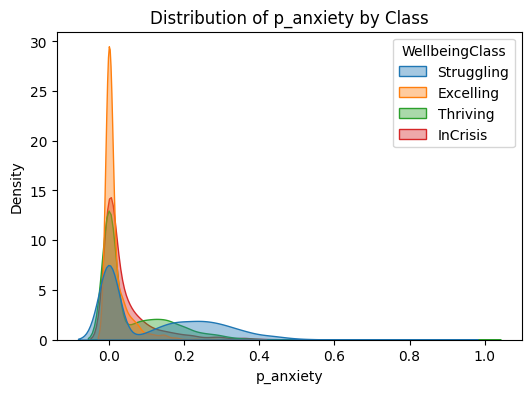

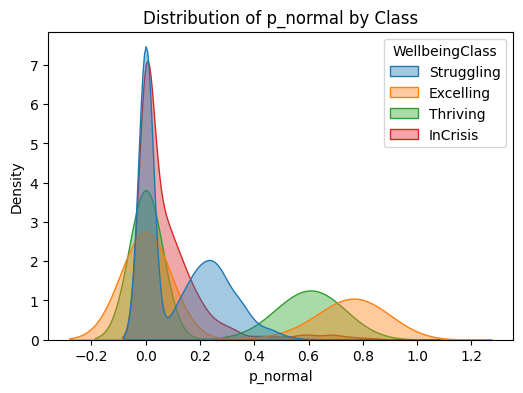

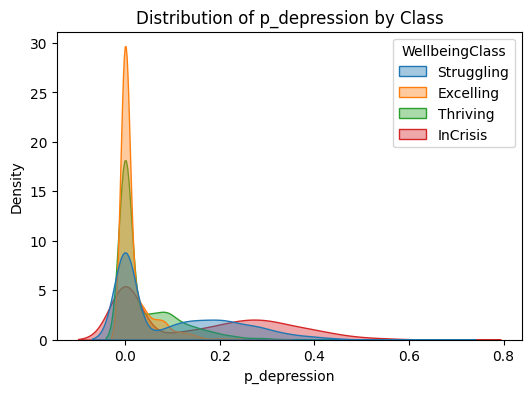

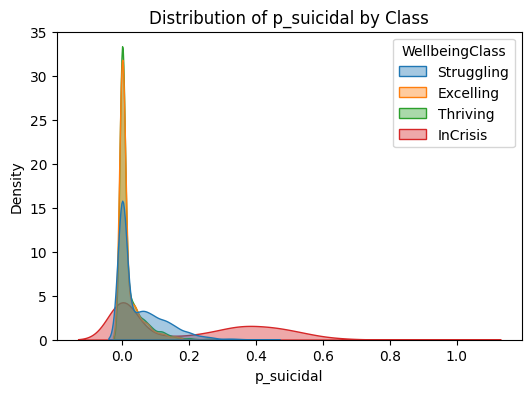

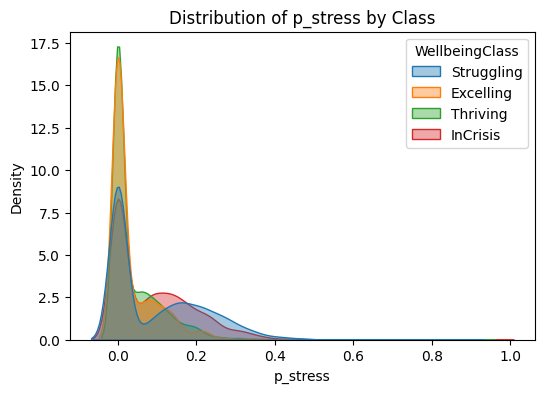

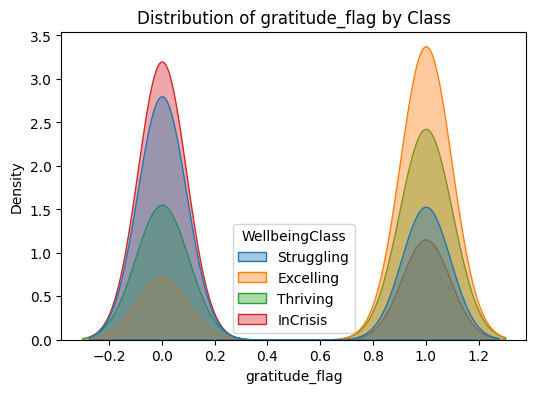

C:\Users\PC\AppData\Local\Temp\ipykernel_24748\1403923627.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)


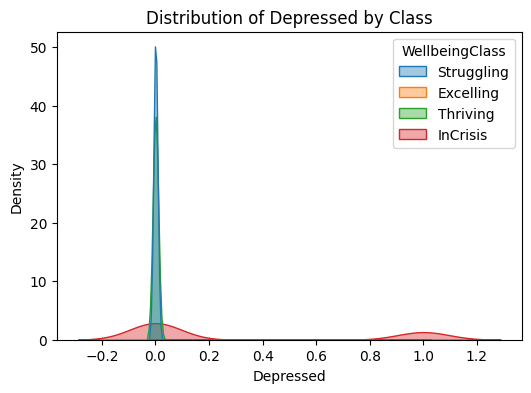

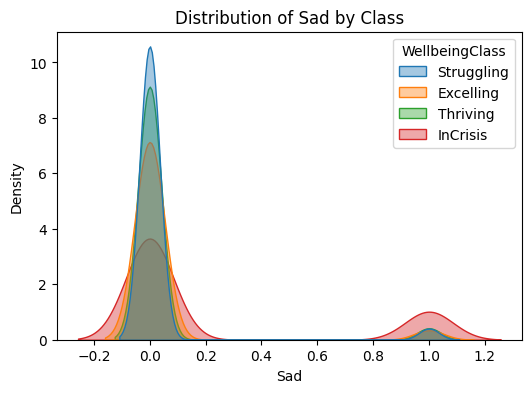

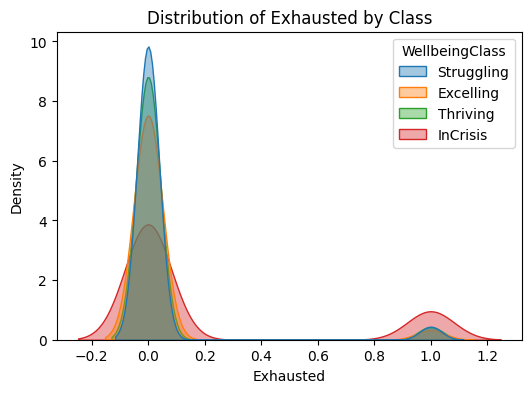

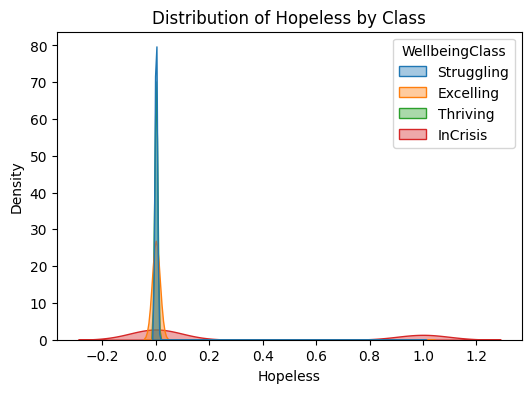

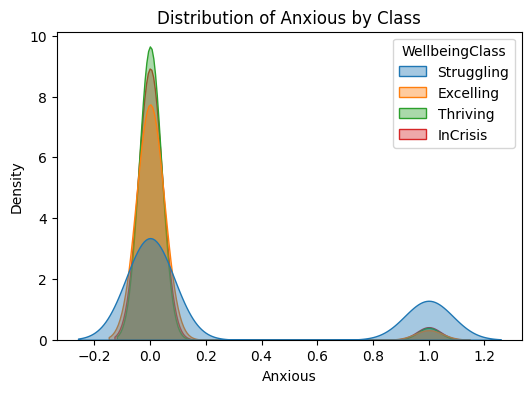

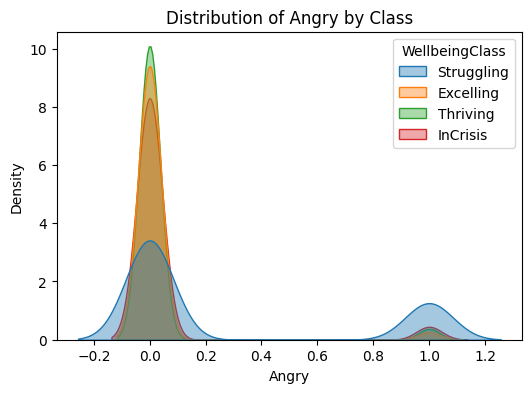

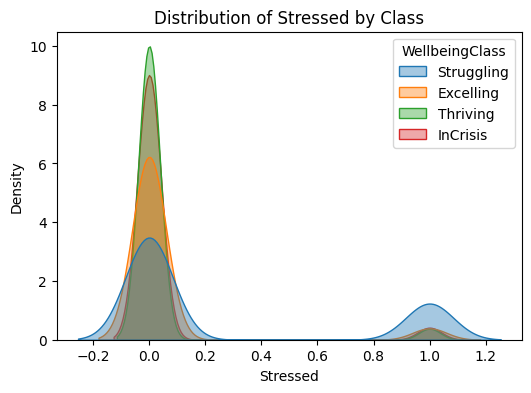

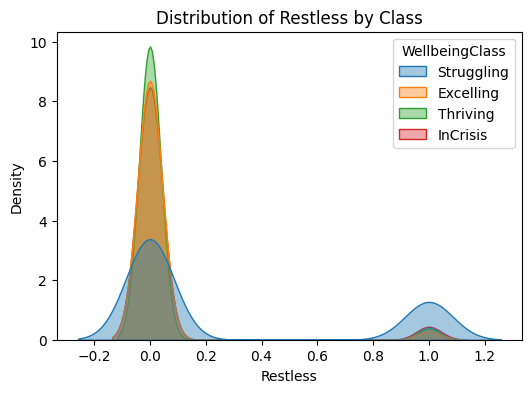

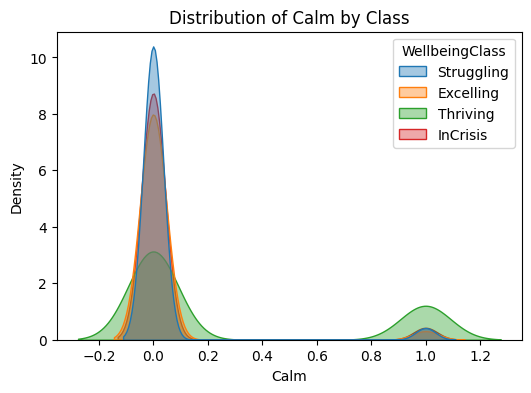

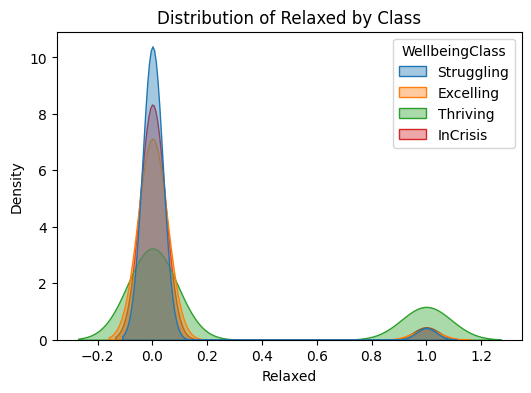

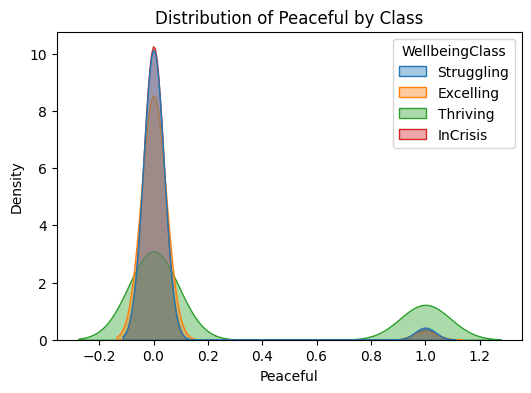

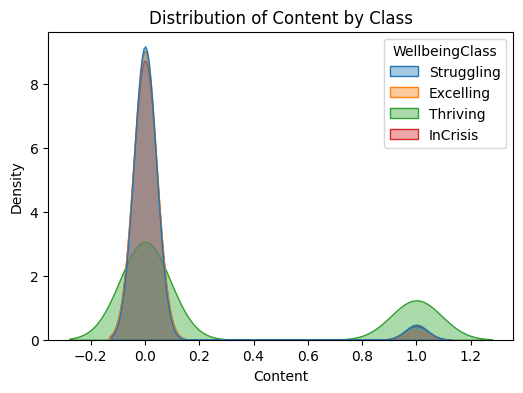

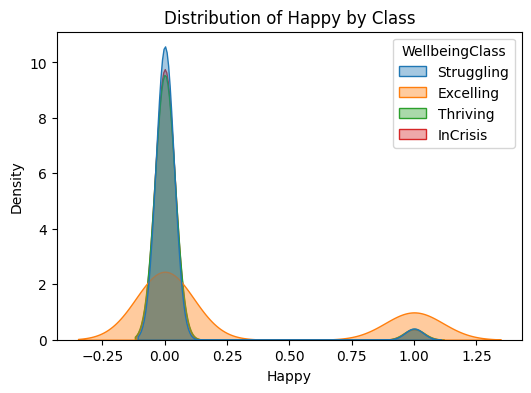

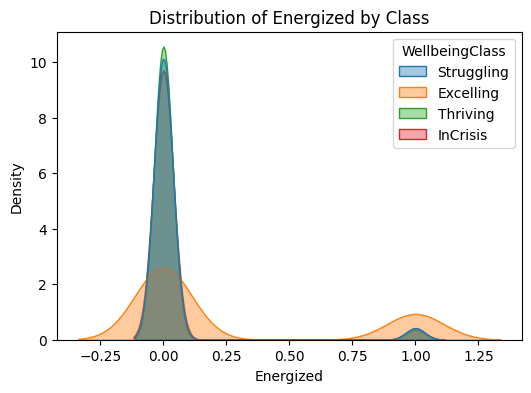

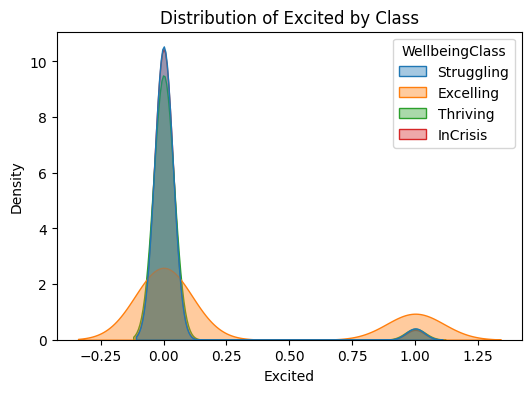

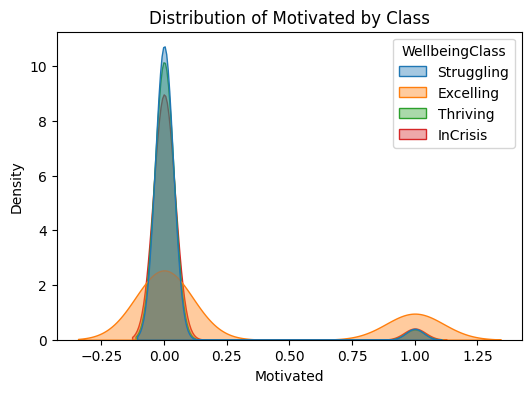

In [5]:
for col in feature_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True, alpha=0.4)
    plt.title(f"Distribution of {col} by Class")
    plt.show()

### **3. Feature-Feature Correlation Heatmap**


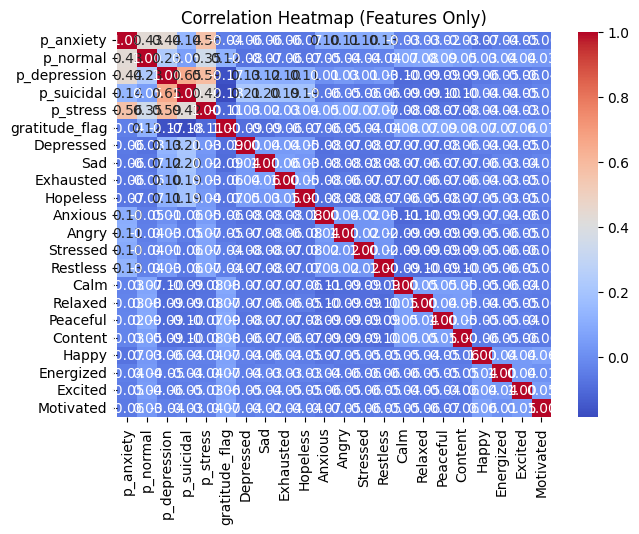

In [6]:
plt.figure(figsize=(7,5))
corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Features Only)")
plt.show()

### **4. Feature-Target Correlation (via encoding)**


In [4]:
le_temp = LabelEncoder()
y_encoded = le_temp.fit_transform(df[target_col])

corr_with_target = df[feature_cols].apply(lambda x: x.corr(pd.Series(y_encoded)))
print("\n🔎 Correlation of each feature with target:\n", corr_with_target)


🔎 Correlation of each feature with target:
 p_anxiety         0.136415
p_normal          0.101290
p_depression     -0.145273
p_suicidal       -0.280192
p_stress         -0.063905
gratitude_flag    0.049397
Depressed        -0.261362
Sad              -0.146870
Exhausted        -0.124856
Hopeless         -0.271166
Anxious           0.044423
Angry             0.041833
Stressed          0.029130
Restless          0.043233
Calm              0.261983
Relaxed           0.240356
Peaceful          0.282063
Content           0.272596
Happy            -0.183282
Energized        -0.178499
Excited          -0.166246
Motivated        -0.187985
dtype: float64


### **5. ANOVA F-test (Feature importance vs target)**


📊 Feature Separability Scores:

           Feature      F-value        p-value  Mutual Information
3       p_suicidal  1272.470463   0.000000e+00            0.207775
9         Hopeless  1159.436051   0.000000e+00            0.119897
6        Depressed  1093.488105   0.000000e+00            0.117608
2     p_depression   550.579153   0.000000e+00            0.156234
5   gratitude_flag   497.810915  1.653351e-301            0.077961
16        Peaceful   494.978759  6.653500e-300            0.056772
14            Calm   446.713030  2.255472e-272            0.046794
17         Content   444.184505  6.384061e-271            0.054401
10         Anxious   435.757776  4.473467e-266            0.059279
13        Restless   423.993578  2.712327e-259            0.063450
11           Angry   417.200190  2.289362e-255            0.055940
0        p_anxiety   406.923519  2.054769e-249            0.180478
15         Relaxed   388.189895  1.609302e-238            0.052965
12        Stressed   383.3360

C:\Users\PC\AppData\Local\Temp\ipykernel_24748\2732673541.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F-value", y="Feature", data=feat_scores, ax=axes[0], palette="viridis")
C:\Users\PC\AppData\Local\Temp\ipykernel_24748\2732673541.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mutual Information", y="Feature", data=feat_scores.sort_values("Mutual Information", ascending=False), ax=axes[1], palette="magma")


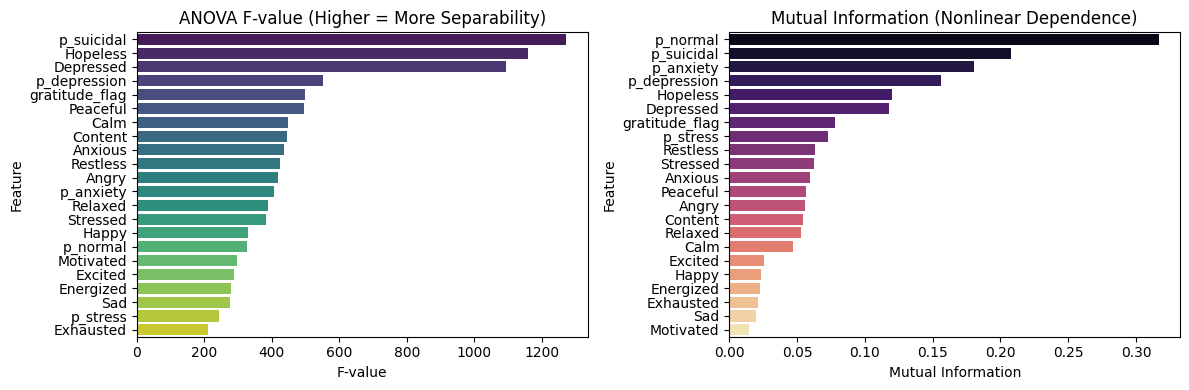

In [8]:
f_vals, p_vals = f_classif(df[feature_cols], y_encoded)
mi_vals = mutual_info_classif(df[feature_cols], y_encoded, random_state=42)

feat_scores = pd.DataFrame({
    "Feature": feature_cols,
    "F-value": f_vals,
    "p-value": p_vals,
    "Mutual Information": mi_vals
}).sort_values("F-value", ascending=False)

print("\n📊 Feature Separability Scores:\n")
print(feat_scores)

# --- Plot F-test and MI as bar chart ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(x="F-value", y="Feature", data=feat_scores, ax=axes[0], palette="viridis")
axes[0].set_title("ANOVA F-value (Higher = More Separability)")

sns.barplot(x="Mutual Information", y="Feature", data=feat_scores.sort_values("Mutual Information", ascending=False), ax=axes[1], palette="magma")
axes[1].set_title("Mutual Information (Nonlinear Dependence)")

plt.tight_layout()
plt.show()

### **6. Pairplot (Scatter matrix)**

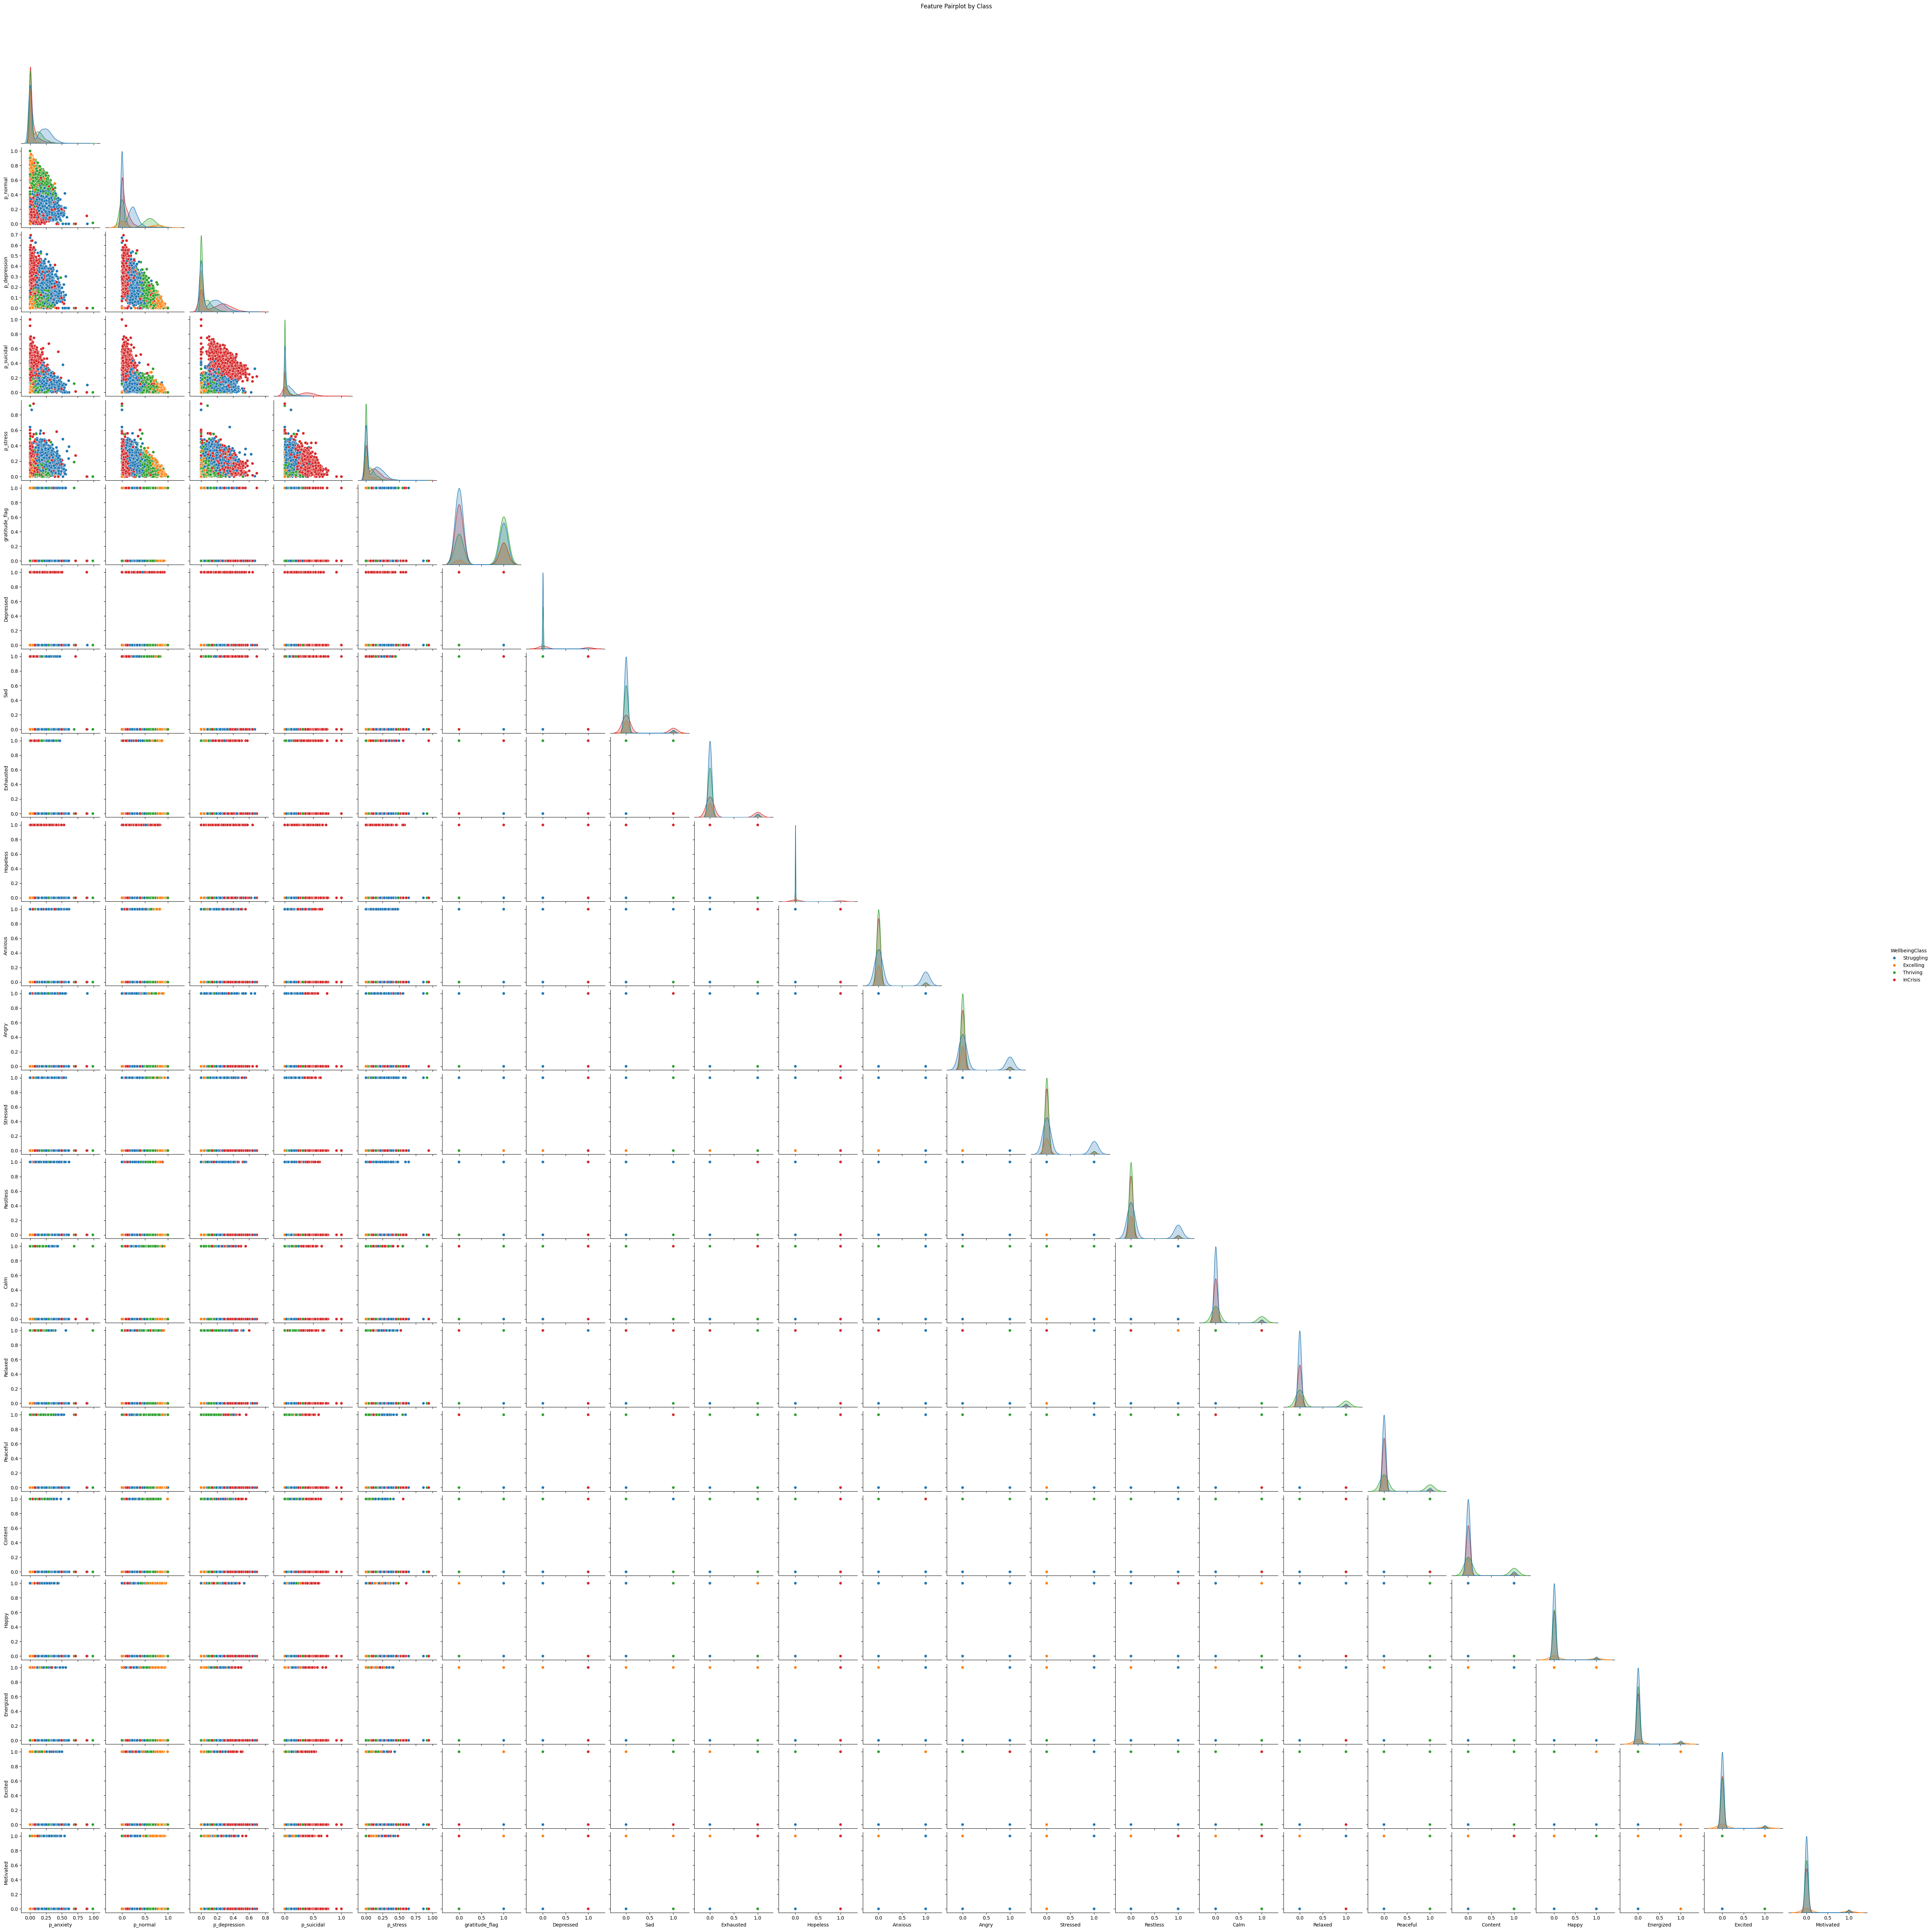

In [9]:
sns.pairplot(df[feature_cols + [target_col]], hue=target_col, diag_kind="kde", corner=True)
plt.suptitle("Feature Pairplot by Class", y=1.02)
plt.show()

### **7. PCA Visualization (2D Projection)**

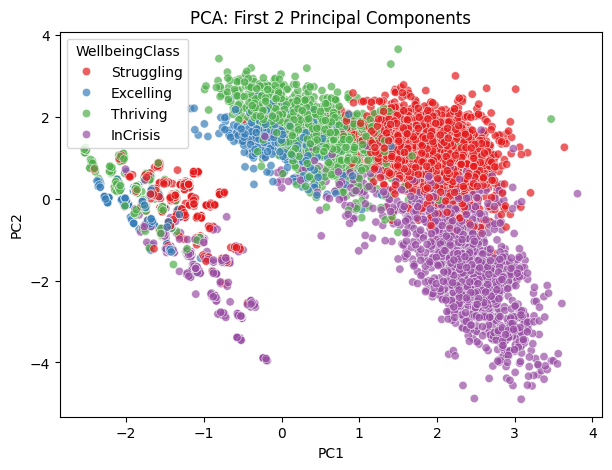

In [10]:
X_scaled = StandardScaler().fit_transform(df[feature_cols])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df[target_col] = df[target_col]

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=target_col, alpha=0.7, palette="Set1")
plt.title("PCA: First 2 Principal Components")
plt.show()

## Data Pre-processing


Before dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64

After dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64


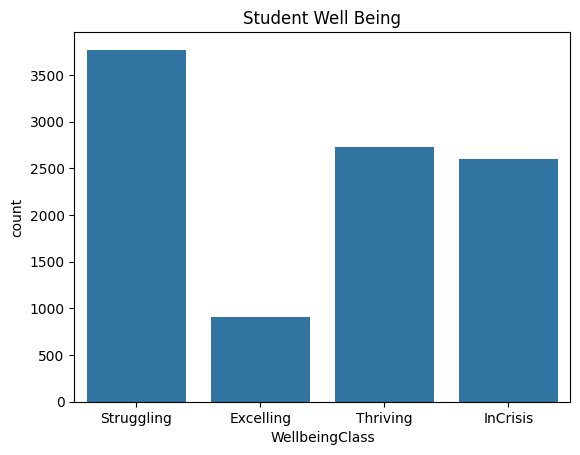

In [5]:
# Check for missing values
print("Before dropping:")
print(df[feature_cols].isna().sum())


# Drop the missing values
df = df.dropna()

# Check if missing values were dropped
print("\nAfter dropping:")
print(df[feature_cols].isna().sum())

# Class distribution
sns.countplot(x=target_col, data=df)
plt.title('Student Well Being')
plt.show()

In [6]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Encode categorical features before splitting
X_encoded = pd.get_dummies(X)

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Training set features dtype:\n", X_train.dtypes.unique())  # Should show only numeric types

Training set features dtype:
 [dtype('float64') dtype('int64')]


## Model training


In [7]:
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Param grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on original (imbalanced) training data
grid_search.fit(X_train, y_train)

# Save best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, MODEL_PATH)
joblib.dump(le, MODEL_LABEL)

print("✅ Best Parameters:", grid_search.best_params_)

✅ Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


## Model Evaluation


✅ Cross-Validation Results Summary:



,mean_test_score,std_test_score,params
0,0.910051,0.007927,"{'classifier__max_depth': None, 'classifier__m..."
1,0.910051,0.007927,"{'classifier__max_depth': None, 'classifier__m..."
2,0.910051,0.007927,"{'classifier__max_depth': None, 'classifier__m..."
3,0.909294,0.008436,"{'classifier__max_depth': None, 'classifier__m..."
4,0.909294,0.008436,"{'classifier__max_depth': None, 'classifier__m..."
...,...,...,...
187,0.713520,0.009441,"{'classifier__max_depth': 3, 'classifier__max_..."
188,0.713520,0.009441,"{'classifier__max_depth': 3, 'classifier__max_..."
189,0.712826,0.005555,"{'classifier__max_depth': 3, 'classifier__max_..."
190,0.712826,0.005555,"{'classifier__max_depth': 3, 'classifier__max_..."



📊 Classification Report (Test Set):



,precision,recall,f1-score,support
Excelling,0.803,0.768,0.785,181.000
InCrisis,0.936,0.927,0.931,520.000
Struggling,0.893,0.918,0.905,754.000
Thriving,0.883,0.870,0.876,545.000
accuracy,0.894,0.894,0.894,0.894
macro avg,0.879,0.871,0.875,2000.000
weighted avg,0.893,0.894,0.893,2000.000



🎯 Key Performance Metrics:



,Metric,Score
0,Accuracy,0.8935
1,Balanced Accuracy,0.8706
2,Precision (Macro),0.8787
3,Recall (Macro),0.8706
4,F1-Score (Macro),0.8745
5,ROC AUC (Macro),0.9793
6,Matthews Correlation Coefficient,0.8492



📝 Metric Explanations:
• Accuracy: Overall correctness (can be misleading with imbalanced data)
• Balanced Accuracy: Average of recall per class (better for imbalanced data)
• Precision (Macro): Average precision across all classes (unweighted)
• Recall (Macro): Average recall across all classes (unweighted)
• F1-Score (Macro): Harmonic mean of precision and recall (unweighted)
• ROC AUC: Area under ROC curve (measures class separability)
• MCC: Correlation between predictions and truth (-1 to +1, accounts for imbalance)

🔎 Confusion Matrix:



,Pred_Excelling,Pred_InCrisis,Pred_Struggling,Pred_Thriving
True_Excelling,139,4,14,24
True_InCrisis,7,482,25,6
True_Struggling,12,17,692,33
True_Thriving,15,12,44,474


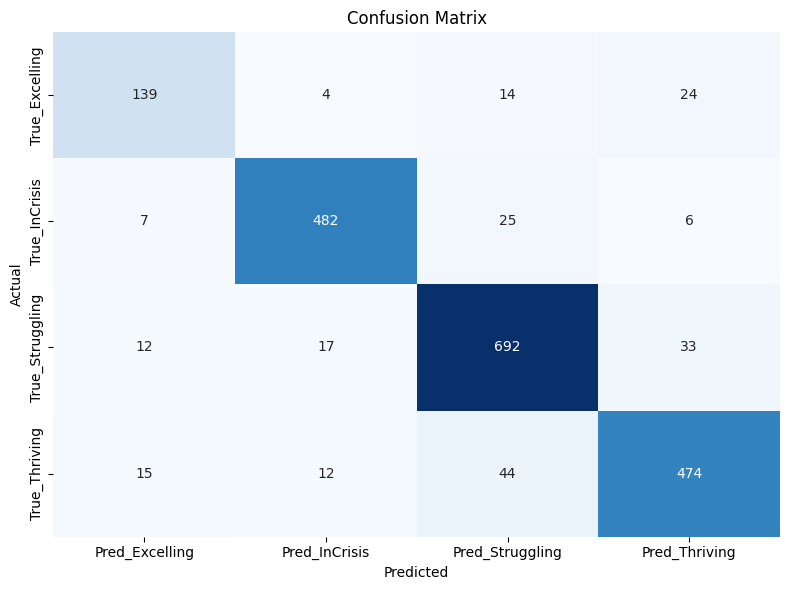

In [8]:
# --- Cross-Validation Results ---
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_summary = cv_results_df[['mean_test_score', 'std_test_score', 'params']] \
    .sort_values(by='mean_test_score', ascending=False) \
    .reset_index(drop=True)

print("\n✅ Cross-Validation Results Summary:\n")
display(cv_summary)

# --- Predictions on Test Set ---
y_pred = grid_search.predict(X_test)

# Decode labels back to class names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
class_names = le.classes_

# --- Classification Report ---
report_dict = classification_report(
    y_test_labels, y_pred_labels, labels=class_names,
    output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report_dict).T

print("\n📊 Classification Report (Test Set):\n")
display(report_df.round(3))

# --- Key Performance Metrics ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_labels, y_pred_labels)
balanced_acc = balanced_accuracy_score(y_test_labels, y_pred_labels)
precision_macro = precision_score(y_test_labels, y_pred_labels, average='macro', zero_division=0)
recall_macro = recall_score(y_test_labels, y_pred_labels, average='macro', zero_division=0)
f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro', zero_division=0)
mcc = matthews_corrcoef(y_test_labels, y_pred_labels)

# ROC AUC (multiclass)
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))
y_pred_proba = grid_search.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro', multi_class='ovr')

# Display metrics in a clean table
metrics_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Balanced Accuracy', 
        'Precision (Macro)',
        'Recall (Macro)',
        'F1-Score (Macro)',
        'ROC AUC (Macro)',
        'Matthews Correlation Coefficient'
    ],
    'Score': [
        accuracy,
        balanced_acc,
        precision_macro,
        recall_macro,
        f1_macro,
        roc_auc,
        mcc
    ]
})

print("\n🎯 Key Performance Metrics:\n")
display(metrics_df.round(4))

print("\n📝 Metric Explanations:")
print("• Accuracy: Overall correctness (can be misleading with imbalanced data)")
print("• Balanced Accuracy: Average of recall per class (better for imbalanced data)")
print("• Precision (Macro): Average precision across all classes (unweighted)")
print("• Recall (Macro): Average recall across all classes (unweighted)")
print("• F1-Score (Macro): Harmonic mean of precision and recall (unweighted)")
print("• ROC AUC: Area under ROC curve (measures class separability)")
print("• MCC: Correlation between predictions and truth (-1 to +1, accounts for imbalance)")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)

cm_df = pd.DataFrame(
    cm, index=[f"True_{cls}" for cls in class_names],
    columns=[f"Pred_{cls}" for cls in class_names]
)

print("\n🔎 Confusion Matrix:\n")
display(cm_df)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


---
## **Make Predictions with Custom Input**

In [17]:
# Load the saved model
loaded_model = joblib.load(MODEL_PATH)

# Define a function to make predictions
def predict_wellbeing(input_data):
    """
    Predict wellbeing class from input features.
    
    Parameters:
    -----------
    input_data : dict
        Dictionary containing all feature values
        
    Returns:
    --------
    prediction : str
        Predicted wellbeing class
    probabilities : dict
        Probability for each class
    """
    # Create DataFrame from input
    input_df = pd.DataFrame([input_data])
    
    # Ensure all columns from training are present
    # Add missing columns with 0 values
    for col in X_encoded.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match training data
    input_df = input_df[X_encoded.columns]
    
    # Make prediction
    prediction_encoded = loaded_model.predict(input_df)[0]
    prediction = le.inverse_transform([prediction_encoded])[0]
    
    # Get probabilities
    proba = loaded_model.predict_proba(input_df)[0]
    probabilities = {class_name: prob for class_name, prob in zip(class_names, proba)}
    
    return prediction, probabilities

# Example: Create sample input
sample_input = {
    "p_anxiety": 0.3,
    "p_normal": 0.4,
    "p_depression": 0.1,
    "p_suicidal": 0.05,
    "p_stress": 0.15,
    "gratitude_flag": 1,
    "Depressed": 0,
    "Sad": 0,
    "Exhausted": 0,
    "Hopeless": 0,
    "Anxious": 0,
    "Angry": 0,
    "Stressed": 0,
    "Restless": 0,
    "Calm": 1,
    "Relaxed": 1,
    "Peaceful": 0,
    "Content": 1,
    "Happy": 0,
    "Energized": 0,
    "Excited": 0,
    "Motivated": 0,
    "flipfeel_incrisis_pct": 0,
    "flipfeel_struggling_pct": 0,
    "flipfeel_thriving_pct": 0.4,
    "flipfeel_excelling_pct": 0.6 
}

# Make prediction
predicted_class, class_probabilities = predict_wellbeing(sample_input)

print("🔮 Prediction for Sample Input:")
print(f"\n✅ Predicted Class: {predicted_class}")
print("\n📊 Class Probabilities:")
for cls, prob in sorted(class_probabilities.items(), key=lambda x: x[1], reverse=True):
    print(f"   {cls}: {prob:.4f} ({prob*100:.2f}%)")


🔮 Prediction for Sample Input:

✅ Predicted Class: Thriving

📊 Class Probabilities:
   Thriving: 0.4856 (48.56%)
   Struggling: 0.2755 (27.55%)
   Excelling: 0.1874 (18.74%)
   InCrisis: 0.0514 (5.14%)


### **Interactive Prediction - Enter Your Own Values**

In [19]:
# ========================================
# CUSTOMIZE YOUR INPUT HERE
# ========================================
# Change the values below to make your own prediction
# Values should typically be between 0 and 1

your_input = {
    # Probability scores from NLP model (should sum to ~1.0)
    "p_anxiety": 0.2,      # Probability of anxiety detected
    "p_normal": 0.5,       # Probability of normal state
    "p_depression": 0.1,   # Probability of depression detected
    "p_suicidal": 0.05,    # Probability of suicidal thoughts detected
    "p_stress": 0.15,      # Probability of stress detected
    
    # Gratitude flag (0 or 1)
    "gratitude_flag": 1,   # 1 = gratitude expressed, 0 = not expressed
    
    # Negative emotion indicators (0-1 scale)
    "Depressed": 0,
    "Sad": 0,
    "Exhausted": 0,
    "Hopeless": 1,
    "Anxious": 0,
    "Angry": 1,
    "Stressed": 0,
    "Restless": 1,
    
    # Positive emotion indicators (0-1 scale)
    "Calm": 0,
    "Relaxed": 0,
    "Peaceful": 0,
    "Content": 0,
    "Happy": 0,
    "Energized": 0,
    "Excited": 0,
    "Motivated": 0,

    "flipfeel_incrisis_pct": 0.5,
    "flipfeel_struggling_pct": 0.5,
    "flipfeel_thriving_pct": 0.0,
    "flipfeel_excelling_pct": 0.0 
}

# Make prediction with your custom input
your_predicted_class, your_class_probabilities = predict_wellbeing(your_input)

print("🔮 YOUR PREDICTION:")
print("=" * 50)
print(f"\n✅ Predicted Wellbeing Class: {your_predicted_class}")
print("\n📊 Confidence Levels for Each Class:")
print("-" * 50)
for cls, prob in sorted(your_class_probabilities.items(), key=lambda x: x[1], reverse=True):
    bar = "█" * int(prob * 30)
    print(f"   {cls:20s} {prob:.4f} ({prob*100:5.2f}%) {bar}")

print("\n" + "=" * 50)


🔮 YOUR PREDICTION:

✅ Predicted Wellbeing Class: InCrisis

📊 Confidence Levels for Each Class:
--------------------------------------------------
   InCrisis             0.5110 (51.10%) ███████████████
   Struggling           0.3643 (36.43%) ██████████
   Thriving             0.0996 ( 9.96%) ██
   Excelling            0.0251 ( 2.51%) 

